# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filtering HRV data

When working with HRV data, a few steps are essential for getting correct results in the analysis. Ectopic beats, as well as noise and measurement errors can severely affect the calculation for traditional time domain features for HRV, making it imperative that we clean the data beforehand.

Text(0.5, 1.0, 'Raw 24h HRV data of CHF patient')

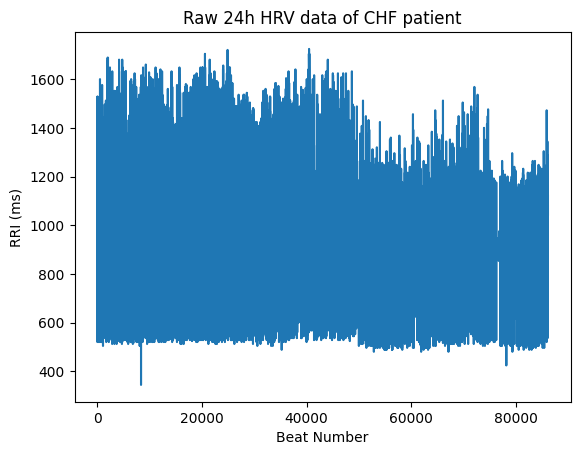

In [75]:
# Opening and displaying sample HRV data
hrv = pd.read_csv('../data/example_hrv.csv', header=None)

plt.plot(hrv)
plt.xlabel('Beat Number')
plt.ylabel('RRI (ms)')
plt.title('Raw 24h HRV data of CHF patient')

Now, we can see that the data is pretty noisy, so we will start with the pre-processing.

In [76]:
# Replace any missing data or non-numeric values by the interpolation of the data    
hrv[0] = pd.to_numeric(hrv[0], 'coerce').interpolate()

# Generate time index from the data
hrv['Time'] = pd.to_datetime(hrv[0].cumsum(), unit='ms', errors='coerce')
hrv = hrv.set_index('Time')

# If you want to select only the initial x hours of data, you can use the line below
# (replace x by the number of hours)
# hrv_signal = hrv_signal[hrv_signal.index<=hrv_signal.index[0]+pd.to_timedelta(x, unit='h', errors='coerce')]

# Notice that only the time matters, the date is irrelevant for our purposes
hrv

,0
Time,
1970-01-01 00:00:01.032,1032
1970-01-01 00:00:02.072,1040
1970-01-01 00:00:03.104,1032
1970-01-01 00:00:04.152,1048
1970-01-01 00:00:05.200,1048
...,...
1970-01-01 23:41:19.256,1080
1970-01-01 23:41:20.328,1072
1970-01-01 23:41:21.440,1112


Now we can start by removing data that is above the maximum allowed threshold or below the minimum allowed threshold. While we are at it, we will also remove values that have too much difference when compared with the previous one.

Text(0.5, 1.0, 'Filtered 24h HRV data of CHF patient')

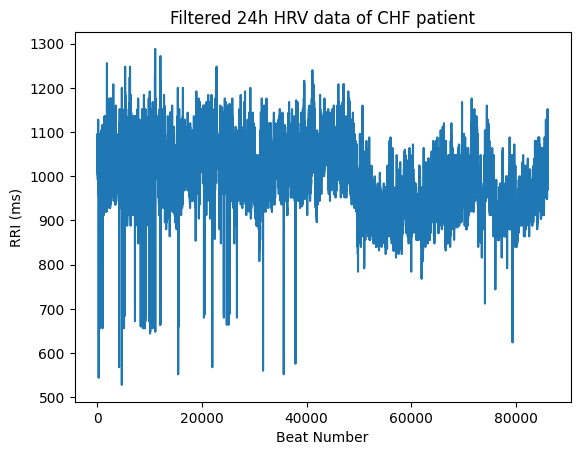

In [77]:
# ----- Minimum and Maximum ------- #
# These are the values of the minimum and maximum RRI acceptable. Choose these according 
# to your needs.
# Minimum: Usually between ~200-300ms
# Maximum: Usually between ~1600-2000ms
threshold_min = 250
threshold_max = 1600


# Replace values off the range by NaN
hrv[(hrv <= threshold_min) | (hrv >= threshold_max)] = np.NaN

# ----- Differences ------- #
# This is the maximum allowed difference between points in percentages
max_difference = 0.2

# Calculate the distance between successive points and save it as a column
hrv['dRRI'] = (hrv[0].diff().fillna(0)).abs()

# Calculate the percentage of change between the points
thresholds = hrv.dRRI/hrv[0]
# Replace values with a larger difference with NaN
hrv.iloc[thresholds > max_difference, 0] = np.NaN

# Alternatively, you can set an absolute maximum difference by running the command below
# instead of the two commands above
# hrv[hrv.dRRI > max_threshold] = np.NaN

# ---- Finishing ----- #
# Now that the outliers were removed, we replace them by interpolating the data
interpolation_method = 'linear' # Could be 'spline' or anything else
hrv = hrv.interpolate(method=interpolation_method).drop(columns='dRRI')


plt.plot(hrv.values)
plt.xlabel('Beat Number')
plt.ylabel('RRI (ms)')
plt.title('Filtered 24h HRV data of CHF patient')

Much better now! Another thing that some types of analysis (specially frequency based and scale dependent analysys) require is for us to resample the data so that all points have a fixed spacing between them, so this is what we'll be doing now.

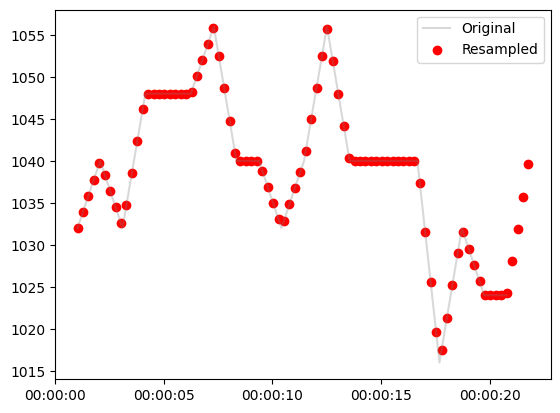

In [78]:
fs = 4 # New resampling frequency in Hz (usually between 2Hz and 5Hz is good)

tmp = hrv.copy() # Saving a copy just to plot at the end

# Generate new time points in which the data will be resampled
# This is done by generating equally spaced points starting from the initial time
window = int(fs*(hrv.index[-1]-hrv.index[0]).total_seconds())
start = hrv.index[0]
t = [start + pd.Timedelta(x/fs, 's') for x in range(window)]

# Add this new timestamps to the index
df = pd.DataFrame(t, columns=['Time'])
df = df.set_index('Time')
df['inter'] = 1
df = df.merge(hrv, how='outer', left_index=True, right_index=True)
sel = df.inter == 1

# Interpolate data (this time the 'time' interpolation is used to take into
# account the time differences)
df = df.interpolate('time')

# Select only the points that were interpolated
hrv = df[sel].drop(columns=['inter'])

plt.plot(
    tmp[tmp.index < tmp.index[20]],
    label='Original',
    alpha=0.3,
    color='gray'
    )
plt.scatter(
    hrv.index[hrv.index < tmp.index[20]], 
    hrv[hrv.index < tmp.index[20]][0], 
    color='r',
    label='Resampled'
    )

plt.legend()

With this, we finished our pre-processing of the HRV data and are ready to use it for our other applications! I implemented this functions in a python file (utils/utils.py) so that they can be easily imported and used when working on your own projects, so feel free to use it if you wish. Other libraries that also do similar things already exist in Python (hrv_analysis, hrv, pyhrv, etc), so this was more to describe the process of how it works. Remember to always check the final clean data to make sure that it looks good before starting your analysis.

In [81]:
# Final resampled and interpolated data as an array
clean_hrv = hrv.to_numpy().flatten()

clean_hrv

array([1032.        , 1033.92307692, 1035.84615385, ..., 1061.57142857,
       1079.42857143, 1097.28571429])

# Time Domain Features

Now that we have the processed time series we are going to

# Frequency Domain Features